# A new Jazz Club in Paris - Capstone Project

## Table of Contents

1. [Data acquisition and Cleaning](#data_acq_cleaning)


<hr>

In [1]:
import pandas as pd
import numpy as np
import folium
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

## Data acquisition and Cleaning <a id="data_acq_cleaning"></a>

### Retrieve neighborhoods

Let's first scrape our wikipedia page using BeautifulSoup.

In [2]:
postal_code_url = requests.get('https://en.wikipedia.org/wiki/Quarters_of_Paris').text
soup = BeautifulSoup(postal_code_url,'lxml')

In [177]:
My_table = soup.find('table',{'class':'wikitable centre'})

#Put into pandas dataframe
df = pd.read_html(str(My_table))[0]

#Drop unecessary data such as population, area, and map
#df.drop(['Population in1999[3]','Area(hectares)[3]','Map'], axis=1, inplace=True)

#Rename columns to have something nice
df.rename(columns={"Arrondissement(Districts)": "Arrondissement", "Quartiers(Quarters)": "Quartiers", "Quartiers(Quarters).1": "Quartier Name"}, inplace=True)
df.head(10)

Arrondissement Quartiers  \
0     1st arrondissement(Called "du Louvre")       1st   
1     1st arrondissement(Called "du Louvre")       2nd   
2     1st arrondissement(Called "du Louvre")       3rd   
3     1st arrondissement(Called "du Louvre")       4th   
4  2nd arrondissement(Called "de la Bourse")       5th   
5  2nd arrondissement(Called "de la Bourse")       6th   
6  2nd arrondissement(Called "de la Bourse")       7th   
7  2nd arrondissement(Called "de la Bourse")       8th   
8     3rd arrondissement(Called "du Temple")       9th   
9     3rd arrondissement(Called "du Temple")      10th   

               Quartier Name  Population in1999[3]  Area(hectares)[3]  Map  
0  Saint-Germain-l'Auxerrois                  1672               86.9  NaN  
1                 Les Halles                  8984               41.2  NaN  
2               Palais-Royal                  3195               27.4  NaN  
3              Place-Vendôme                  3044               26.9  NaN  
4                    Gaillon                  1345               18.8  NaN  
5                   Vivienne                  2917               24.4  NaN  
6                       Mail                  5783               27.8  NaN  
7             Bonne-Nouvelle                  9595               28.2  NaN  
8            Arts-et-Métiers                  9560               31.8  NaN  
9             Enfants-Rouges                  8562               27.2  NaN

In [4]:
# Je dois prendre les arrondissements et leur mettre le code postal... 
# POur ça, je prends la colonne arrondissements et j'enlève les duplicats.

df_arrondissements = df[['Arrondissement']].drop_duplicates(ignore_index=True)
df_arrondissements

postal_code=[]
arrondissement_nb=[]
#Postal code
for index, row in df_arrondissements.iterrows():
    if (index+1) < 10:
        postal_code.append('7510'+str(index+1))
    else:
        postal_code.append('751'+str(index+1))
    arrondissement_nb.append(index+1)

df_arrondissements['Code']=postal_code
df_arrondissements['Arrondissement_nb']=arrondissement_nb

df = pd.merge(df_arrondissements,df)

## Découpe en arrondissements

In [5]:
paris_arrondissements_geo = 'arrondissements-2.geojson'

In [6]:
paris_longitude = 2.3488
paris_latitude = 48.8534

paris_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=paris_arrondissements_geo,
    data=df,
    columns=['Code', 'Area(hectares)[3]'],
    key_on='feature.properties.code',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Neighborhoods paris').add_to(paris_map)

# display map
paris_map

In [7]:
latitude = []
longitude = []

geolocator = Nominatim(user_agent="fr_explorer")

for index, row in df.iterrows():
    location = geolocator.geocode(row[4]+', Paris')
    print(row[4])
    latitude.append(location.latitude)
    longitude.append(location.longitude)
    
# we put the result of the loop in new columns 'latitude' and 'longitude'
df['Latitude'] = latitude
df['Longitude'] = longitude

Saint-Germain-l'Auxerrois
Les Halles
Palais-Royal
Place-Vendôme
Gaillon
Vivienne
Mail
Bonne-Nouvelle
Arts-et-Métiers
Enfants-Rouges
Archives
Sainte-Avoye
Saint-Merri
Saint-Gervais
Arsenal
Notre-Dame
Quartier Saint-Victor
Jardin-des-Plantes
Val-de-Grâce
Sorbonne
Monnaie
Odéon
Notre-Dame-des-Champs
Saint-Germain-des-Prés
Saint-Thomas-d'Aquin
Les Invalides
École-Militaire
Gros-Caillou
Champs-Élysées
Faubourg-du-Roule
La Madeleine
Europe
Saint-Georges
Chaussée-d'Antin
Faubourg-Montmartre
Rochechouart
Saint-Vincent-de-Paul
Porte-Saint-Denis
Porte-Saint-Martin
Hôpital-Saint-Louis
Folie-Méricourt
Saint-Ambroise
La Roquette
Sainte-Marguerite
Bel-Air
Picpus
Bercy
Quinze-Vingts
Salpêtrière
La Gare
Maison-Blanche
Croulebarbe
Montparnasse
Parc Montsouris
Petit-Montrouge
Plaisance
Saint-Lambert
Necker
Grenelle
Javel
Auteuil
La Muette
Porte-Dauphine
Chaillot
Les Ternes
Plaine Monceau
Batignolles
Épinettes
Grandes-Carrières
Clignancourt
Goutte-d'Or
La Chapelle
La Villette
Pont-de-Flandre
Amérique
Com

In [8]:
#Display Arrondissements limits and Quartiers

for lat, lng, label in zip(df.Latitude, df.Longitude, df['Quartier Name']):
    folium.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color='blue',
        fill=True,
        popup=label,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(paris_map)

# display map
paris_map

## Découpe en quartiers

In [9]:
# REFERENCE IRIS POUR DECOUPER QUARTIERS

df_IRIS = pd.read_excel('reference_IRIS_geo2019.xls',
                       skiprows=range(5))
df_IRIS.head()

CODE_IRIS                                      LIB_IRIS TYP_IRIS  \
0  010010000  L'Abergement-Clémenciat (commune non irisée)        Z   
1  010020000    L'Abergement-de-Varey (commune non irisée)        Z   
2  010040101              Les Perouses-Triangle d'Activité        H   
3  010040102                                 Longeray-Gare        H   
4  010040201                Centre-Saint-Germain-Vareilles        H   

   MODIF_IRIS GRD_QUART DEPCOM                   LIBCOM UU2010  REG DEP  
0           0   0100100  01001  L'Abergement-Clémenciat  01000   84  01  
1           0   0100200  01002    L'Abergement-de-Varey  01000   84  01  
2           0   0100401  01004        Ambérieu-en-Bugey  01302   84  01  
3           0   0100401  01004        Ambérieu-en-Bugey  01302   84  01  
4           0   0100402  01004        Ambérieu-en-Bugey  01302   84  01

In [10]:
#Filtre sur les quartiers INSEE qui commencent avec '75'
df_IRIS = df_IRIS.loc[df_IRIS['GRD_QUART'].str.startswith('75', na=False)]

In [11]:
df_IRIS = df_IRIS[['GRD_QUART']].drop_duplicates(ignore_index=True)
df[['INSEE_ID']] = df_IRIS

### Construire l'indice INSEE permettant de récupérer les identifiants des quartiers

In [12]:
code="75101"
i=0
j=0
resp=[]
v=[]

for index, row in df.iterrows():
    if code == row[1]:
        i=i+1;
        j=j+1;
    else:
        i=1
        j=1
        code=row[1]
    resp.append(code+"0"+str(i))
    
    #A EFFACER DES QUE POSSIBLE
    v.append(str(j))

#EFFACER DESQUE POSSIBLE !!!
df['v'] = v
df[['v']]=df[['v']].astype(int)

df[['INSEE_ID']] = resp
df[['INSEE_ID']]=df[['INSEE_ID']].astype(int)
df.head(5)

Arrondissement   Code  Arrondissement_nb  \
0     1st arrondissement(Called "du Louvre")  75101                  1   
1     1st arrondissement(Called "du Louvre")  75101                  1   
2     1st arrondissement(Called "du Louvre")  75101                  1   
3     1st arrondissement(Called "du Louvre")  75101                  1   
4  2nd arrondissement(Called "de la Bourse")  75102                  2   

  Quartiers              Quartier Name  Population in1999[3]  \
0       1st  Saint-Germain-l'Auxerrois                  1672   
1       2nd                 Les Halles                  8984   
2       3rd               Palais-Royal                  3195   
3       4th              Place-Vendôme                  3044   
4       5th                    Gaillon                  1345   

   Area(hectares)[3]  Map   Latitude  Longitude  INSEE_ID  v  
0               86.9  NaN  48.860211   2.336299   7510101  1  
1               41.2  NaN  48.862466   2.346009   7510102  2  
2               27.4  NaN  48.863585   2.336204   7510103  3  
3               26.9  NaN  48.867463   2.329428   7510104  4  
4               18.8  NaN  48.869135   2.332909   7510201  1

### Afficher la vue par quartiers

In [13]:
paris_quartier_geo = 'quartier_paris.geojson'

my_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=paris_quartier_geo,
    data=df,
    columns=['INSEE_ID', 'v'],
    key_on='feature.properties.c_quinsee',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Neighborhoods paris').add_to(my_map)


# loop through the 100 crimes and add each to the map
for lat, lng, name, arrondissement_nb in zip(df.Latitude, df.Longitude, df['Quartier Name'], df.Arrondissement_nb):
    folium.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color='blue',
        fill=True,
        popup=(name+' ('+str(arrondissement_nb)+'e'+')'),
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(my_map)

# display map
my_map

## FOURSQUARE POUR ALLER CHERCHER LES DONNEES QUI M'INTERESSENT

In [19]:
CLIENT_ID = '1UG5N54OGSL3W13G0KBFGEPUUOIS4UD5K11UD1EK5CHGBDSJ' # your Foursquare ID
CLIENT_SECRET = 'NN3CFNBEDB0NUFRW2VIWW3WFVTUOL1IU4E5B4YTC2U1KDTON' # your Foursquare Secret
VERSION = '20200714' # Foursquare API version

### Test d'exploration du quartier latin

In [20]:
# Test and explore the first neighborhood in our dataframe

# Get the neighborhood's latitude and longitude values
neighborhood_latitude = df.loc[19, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[19, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[19, 'Quartier Name'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Sorbonne are 48.84912335, 2.3453251499821075.


In [21]:
#First, let's create the GET request URL :

LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
#url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
url = 'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d1e5931735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d1e5931735&client_id=1UG5N54OGSL3W13G0KBFGEPUUOIS4UD5K11UD1EK5CHGBDSJ&client_secret=NN3CFNBEDB0NUFRW2VIWW3WFVTUOL1IU4E5B4YTC2U1KDTON&v=20200714&ll=48.84912335,2.3453251499821075&radius=500&limit=100'

In [22]:
#Let's send the GET request and examine the resutls
results = requests.get(url).json()
venues = results['response']['venues']
venues

[{'id': '4adcda05f964a520523221e3',
  'name': 'Le Piano Vache',
  'location': {'address': '8 rue Laplace',
   'lat': 48.847266816912025,
   'lng': 2.347707272470676,
   'labeledLatLngs': [{'label': 'display',
     'lat': 48.847266816912025,
     'lng': 2.347707272470676}],
   'distance': 270,
   'postalCode': '75005',
   'cc': 'FR',
   'city': 'Paris',
   'state': 'Île-de-France',
   'country': 'France',
   'formattedAddress': ['8 rue Laplace', '75005 Paris', 'France']},
  'categories': [{'id': '4bf58dd8d48988d11b941735',
    'name': 'Pub',
    'pluralName': 'Pubs',
    'shortName': 'Pub',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1595795583',
  'hasPerk': False},
 {'id': '4b4afc11f964a520899026e3',
  'name': 'Le Caveau des Oubliettes',
  'location': {'address': '52 rue Galande',
   'lat': 48.85200681507648,
   'lng': 2.3467357456684113,
   'labeledLatLngs': [{'label': 'display',
   

In [23]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [24]:
# flatten JSON
nearby_venues = pd.json_normalize(venues)

filter_column = ['name','categories','location.lat','location.lng','location.formattedAddress']
nearby_venues=nearby_venues[filter_column]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

#drop 'categories column'
nearby_venues.drop(['categories'], axis=1, inplace=True)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

name        lat       lng  \
0                 Le Piano Vache  48.847267  2.347707   
1       Le Caveau des Oubliettes  48.852007  2.346736   
2          Caveau de la Huchette  48.852785  2.346305   
3             Aux Trois Mailletz  48.852177  2.346609   
4  Le Petit Journal Saint Michel  48.846467  2.340402   
5                Le Petit Jornal  48.845281  2.340555   
6                         Boub's  48.850926  2.339206   
7                      Piano Bar  48.852967  2.345922   
8                  studio purple  48.847867  2.351259   

                                   formattedAddress   categories  
0              [8 rue Laplace, 75005 Paris, France]          Pub  
1             [52 rue Galande, 75005 Paris, France]    Jazz Club  
2       [5 rue de la Huchette, 75005 Paris, France]    Jazz Club  
3             [56 rue Galande, 75005 Paris, France]    Piano Bar  
4  [71 boulevard Saint-Michel, 75005 Paris, France]    Jazz Club  
5           [Boulevard Saint Michel, Paris, France]    Jazz Club  
6                                          [France]    Jazz Club  
7      [14 rue de la Huchette, 75005 Paris, France]    Piano Bar  
8                                          [France]  Music Venue

In [25]:
#CHECKER TOUTES LES MUSIC VENUES POUR CHAQUE QUARTIER

 Let's create a function to repeat the same process to all the neighborhoods in Paris

In [26]:
def getNearbyMusicVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d1e5931735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request        
        results = requests.get(url).json()['response']['venues']        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['categories'][0]['name'],
            v['location']['lat'], 
            v['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Quartier Name', 
                  'Quartier Latitude', 
                  'Quartier Longitude', 
                  'Venue', 
                  'Venue Category',
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

In [27]:
df.head()

Arrondissement   Code  Arrondissement_nb  \
0     1st arrondissement(Called "du Louvre")  75101                  1   
1     1st arrondissement(Called "du Louvre")  75101                  1   
2     1st arrondissement(Called "du Louvre")  75101                  1   
3     1st arrondissement(Called "du Louvre")  75101                  1   
4  2nd arrondissement(Called "de la Bourse")  75102                  2   

  Quartiers              Quartier Name  Population in1999[3]  \
0       1st  Saint-Germain-l'Auxerrois                  1672   
1       2nd                 Les Halles                  8984   
2       3rd               Palais-Royal                  3195   
3       4th              Place-Vendôme                  3044   
4       5th                    Gaillon                  1345   

   Area(hectares)[3]  Map   Latitude  Longitude  INSEE_ID  v  
0               86.9  NaN  48.860211   2.336299   7510101  1  
1               41.2  NaN  48.862466   2.346009   7510102  2  
2               27.4  NaN  48.863585   2.336204   7510103  3  
3               26.9  NaN  48.867463   2.329428   7510104  4  
4               18.8  NaN  48.869135   2.332909   7510201  1

In [28]:
paris_music_venues = getNearbyMusicVenues(names=df['Quartier Name'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Saint-Germain-l'Auxerrois
Les Halles
Palais-Royal
Place-Vendôme
Gaillon
Vivienne
Mail
Bonne-Nouvelle
Arts-et-Métiers
Enfants-Rouges
Archives
Sainte-Avoye
Saint-Merri
Saint-Gervais
Arsenal
Notre-Dame
Quartier Saint-Victor
Jardin-des-Plantes
Val-de-Grâce
Sorbonne
Monnaie
Odéon
Notre-Dame-des-Champs
Saint-Germain-des-Prés
Saint-Thomas-d'Aquin
Les Invalides
École-Militaire
Gros-Caillou
Champs-Élysées
Faubourg-du-Roule
La Madeleine
Europe
Saint-Georges
Chaussée-d'Antin
Faubourg-Montmartre
Rochechouart
Saint-Vincent-de-Paul
Porte-Saint-Denis
Porte-Saint-Martin
Hôpital-Saint-Louis
Folie-Méricourt
Saint-Ambroise
La Roquette
Sainte-Marguerite
Bel-Air
Picpus
Bercy
Quinze-Vingts
Salpêtrière
La Gare
Maison-Blanche
Croulebarbe
Montparnasse
Parc Montsouris
Petit-Montrouge
Plaisance
Saint-Lambert
Necker
Grenelle
Javel
Auteuil
La Muette
Porte-Dauphine
Chaillot
Les Ternes
Plaine Monceau
Batignolles
Épinettes
Grandes-Carrières
Clignancourt
Goutte-d'Or
La Chapelle
La Villette
Pont-de-Flandre
Amérique
Com

In [29]:
paris_music_venues

Quartier Name  Quartier Latitude  Quartier Longitude  \
0    Saint-Germain-l'Auxerrois          48.860211            2.336299   
1    Saint-Germain-l'Auxerrois          48.860211            2.336299   
2    Saint-Germain-l'Auxerrois          48.860211            2.336299   
3    Saint-Germain-l'Auxerrois          48.860211            2.336299   
4    Saint-Germain-l'Auxerrois          48.860211            2.336299   
..                         ...                ...                 ...   
409                   Charonne          48.854744            2.385356   
410                   Charonne          48.854744            2.385356   
411                   Charonne          48.854744            2.385356   
412                   Charonne          48.854744            2.385356   
413                   Charonne          48.854744            2.385356   

                         Venue                Venue Category  Venue Latitude  \
0    Le Tigre by l'Alternative                     Nightclub       48.864849   
1     Les studios Saint German                     Piano Bar       48.855687   
2                    Jazz Club                     Jazz Club       48.855308   
3                   Don Carlos                   Music Venue       48.854852   
4                          Q&R                     Jazz Club       48.863772   
..                         ...                           ...             ...   
409            Generation 88.2                   Music Venue       48.858878   
410       Espace Métro Accords                   Music Venue       48.854480   
411             Groove Academy  General College & University       48.852361   
412              Y'a d'la voix                   Music Venue       48.850846   
413             Pan Piper Live                   Music Venue       48.858148   

     Venue Longitude  
0           2.335593  
1           2.340168  
2           2.333580  
3           2.337916  
4           2.332568  
..               ...  
409         2.390430  
410         2.384491  
411         2.383150  
412         2.377838  
413         2.388726  

[414 rows x 7 columns]

In [30]:
#LETS DO THE CHOROPLETH >> We will count the number of Music venues by neighborhoods to categorize them

paris_music_venues_grouped_quartier = paris_music_venues[['Quartier Name','Venue']].groupby('Quartier Name').count().reset_index()
paris_music_venues_grouped_quartier.rename(columns={'Venue': 'Music Venue Count'}, inplace=True)

In [31]:
paris_music_venues.loc[paris_music_venues['Venue Category']=='Music Venue']

Quartier Name  Quartier Latitude  Quartier Longitude  \
3    Saint-Germain-l'Auxerrois          48.860211            2.336299   
5    Saint-Germain-l'Auxerrois          48.860211            2.336299   
6    Saint-Germain-l'Auxerrois          48.860211            2.336299   
12                  Les Halles          48.862466            2.346009   
15                  Les Halles          48.862466            2.346009   
..                         ...                ...                 ...   
408                   Charonne          48.854744            2.385356   
409                   Charonne          48.854744            2.385356   
410                   Charonne          48.854744            2.385356   
412                   Charonne          48.854744            2.385356   
413                   Charonne          48.854744            2.385356   

                          Venue Venue Category  Venue Latitude  \
3                    Don Carlos    Music Venue       48.854852   
5    X Trem Venue - Studio Live    Music Venue       48.861270   
6        Paris-Prague Jazz Club    Music Venue       48.857928   
12               Sunset/Sunside    Music Venue       48.859787   
15                   AK Studios    Music Venue       48.859271   
..                          ...            ...             ...   
408                   Aligre FM    Music Venue       48.850474   
409             Generation 88.2    Music Venue       48.858878   
410        Espace Métro Accords    Music Venue       48.854480   
412               Y'a d'la voix    Music Venue       48.850846   
413              Pan Piper Live    Music Venue       48.858148   

     Venue Longitude  
3           2.337916  
5           2.343242  
6           2.335382  
12          2.347769  
15          2.347644  
..               ...  
408         2.387000  
409         2.390430  
410         2.384491  
412         2.377838  
413         2.388726  

[194 rows x 7 columns]

In [32]:
#%ERGE MUSIC VENUES + INSEE ID to display them on the map
paris_music_venues_grouped_quartier = pd.merge(paris_music_venues_grouped_quartier, 
                                               df[['Quartier Name','INSEE_ID']], 
                                               how='left', 
                                               on=['Quartier Name'])

#SOME OF THE NEIGHBORHOODS HAVE 0 AND ARE THUS NOT PRESENT IN THE LIST... 
#WE HAVE TO PUT 0 MANUALLY FOR THOSE

paris_music_venues_grouped_quartier=pd.merge(paris_music_venues_grouped_quartier,
                                             df[['INSEE_ID','Quartier Name']],
                                             how='right',
                                             on=['INSEE_ID'])

paris_music_venues_grouped_quartier.fillna(value=float(0),inplace=True)
paris_music_venues_grouped_quartier.drop(['Quartier Name_x'], axis=1, inplace=True)
paris_music_venues_grouped_quartier.rename(columns={'Quartier Name_y': 'Quartier Name'})



Music Venue Count  INSEE_ID    Quartier Name
0                 1.0   7511903         Amérique
1                 5.0   7510303         Archives
2                 4.0   7510403          Arsenal
3                 5.0   7510301  Arts-et-Métiers
4                 4.0   7511703      Batignolles
..                ...       ...              ...
75                0.0   7511202           Picpus
76                0.0   7511402  Parc Montsouris
77                0.0   7511504            Javel
78                0.0   7511601          Auteuil
79                0.0   7511603   Porte-Dauphine

[80 rows x 3 columns]

In [33]:
paris_quartier_geo = 'quartier_paris.geojson'

my_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=paris_quartier_geo,
    data=paris_music_venues_grouped_quartier,
    columns=["INSEE_ID", 'Music Venue Count'],
    key_on='feature.properties.c_quinsee',
    fill_color='GnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of music venues in a 500m radius').add_to(my_map)

#'BuGn', 'BuPu', 'GnBu',

# loop through the 100 crimes and add each to the map
for lat, lng, venue, venue_category in zip(paris_music_venues['Venue Latitude'], 
                                           paris_music_venues['Venue Longitude'], 
                                           paris_music_venues['Venue'], 
                                           paris_music_venues['Venue Category']):
    folium.CircleMarker(
        [lat, lng],
        radius=3, # define how big you want the circle markers to be
        color='red',
        fill=True,
        popup=(venue+'\n'+'({})'.format(venue_category)),
        fill_color='red',
        fill_opacity=0.6
    ).add_to(my_map)

# display map
my_map

In [34]:
#Top 10 Quartier pour la musique
paris_music_venues_grouped_quartier_top=paris_music_venues_grouped_quartier.sort_values('Music Venue Count', ascending=False).head(10).reset_index(drop=True)
paris_music_venues_grouped_quartier_top.rename(columns={'Quartier Name_y':'Quartier Name'}, inplace=True)

### Most represented music venue in Top 10 ?

In [35]:
df_quartier = paris_music_venues[['Quartier Name','Venue Category']]
df_quartier.set_index('Quartier Name',inplace=True)

In [36]:
top_10_quartier = paris_music_venues_grouped_quartier_top['Quartier Name']

In [37]:
top_10_quartier_cat = df_quartier.loc[top_10_quartier]
top_10_quartier_cat.reset_index(inplace=True)

In [38]:
count_venue_categories = top_10_quartier_cat.groupby('Venue Category').count()
count_venue_categories.rename(columns={'Quartier Name':'Count'},inplace=True)
count_venue_categories.reset_index(inplace=True)
count_venue_categories.sort_values('Count',ascending=True,inplace=True)
count_venue_categories

Venue Category  Count
4            Music School      1
1               Hotel Bar      2
6               Nightclub      2
7   Performing Arts Venue      2
9                     Pub      2
2               Irish Pub      3
0                     Bar      5
10              Rock Club      7
8               Piano Bar      9
3               Jazz Club     35
5             Music Venue     66

<BarContainer object of 11 artists>

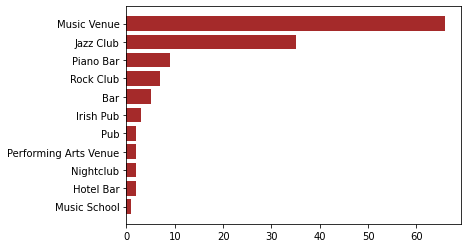

In [39]:
plt.barh(count_venue_categories['Venue Category'],
         count_venue_categories['Count'],
         color='brown',
         align='center')

# Explore and cluster neighborhoods

In [40]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&time={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            any,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Quartier Name', 
                  'Quartier Latitude', 
                  'Quartier Longitude', 
                  'Venue', 
                  'Venue Category',
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

In [41]:
paris_venues = getNearbyVenues(names=df['Quartier Name'],
                               latitudes=df['Latitude'],
                               longitudes=df['Longitude'])

Saint-Germain-l'Auxerrois
Les Halles
Palais-Royal
Place-Vendôme
Gaillon
Vivienne
Mail
Bonne-Nouvelle
Arts-et-Métiers
Enfants-Rouges
Archives
Sainte-Avoye
Saint-Merri
Saint-Gervais
Arsenal
Notre-Dame
Quartier Saint-Victor
Jardin-des-Plantes
Val-de-Grâce
Sorbonne
Monnaie
Odéon
Notre-Dame-des-Champs
Saint-Germain-des-Prés
Saint-Thomas-d'Aquin
Les Invalides
École-Militaire
Gros-Caillou
Champs-Élysées
Faubourg-du-Roule
La Madeleine
Europe
Saint-Georges
Chaussée-d'Antin
Faubourg-Montmartre
Rochechouart
Saint-Vincent-de-Paul
Porte-Saint-Denis
Porte-Saint-Martin
Hôpital-Saint-Louis
Folie-Méricourt
Saint-Ambroise
La Roquette
Sainte-Marguerite
Bel-Air
Picpus
Bercy
Quinze-Vingts
Salpêtrière
La Gare
Maison-Blanche
Croulebarbe
Montparnasse
Parc Montsouris
Petit-Montrouge
Plaisance
Saint-Lambert
Necker
Grenelle
Javel
Auteuil
La Muette
Porte-Dauphine
Chaillot
Les Ternes
Plaine Monceau
Batignolles
Épinettes
Grandes-Carrières
Clignancourt
Goutte-d'Or
La Chapelle
La Villette
Pont-de-Flandre
Amérique
Com

In [42]:
paris_venues.head(5)

Quartier Name  Quartier Latitude  Quartier Longitude  \
0  Saint-Germain-l'Auxerrois          48.860211            2.336299   
1  Saint-Germain-l'Auxerrois          48.860211            2.336299   
2  Saint-Germain-l'Auxerrois          48.860211            2.336299   
3  Saint-Germain-l'Auxerrois          48.860211            2.336299   
4  Saint-Germain-l'Auxerrois          48.860211            2.336299   

                              Venue    Venue Category  Venue Latitude  \
0             Cour Carrée du Louvre  Pedestrian Plaza       48.860360   
1                   Musée du Louvre        Art Museum       48.860847   
2  La Vénus de Milo (Vénus de Milo)           Exhibit       48.859943   
3                     Cour Napoléon             Plaza       48.861172   
4                     Pont des Arts            Bridge       48.858565   

   Venue Longitude  
0         2.338543  
1         2.336440  
2         2.337234  
3         2.335088  
4         2.337635

## Analysis of each neighborhood

In [43]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Quartier Name'] = paris_venues['Quartier Name'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

Quartier Name  Accessories Store  Afghan Restaurant  \
0  Saint-Germain-l'Auxerrois                  0                  0   
1  Saint-Germain-l'Auxerrois                  0                  0   
2  Saint-Germain-l'Auxerrois                  0                  0   
3  Saint-Germain-l'Auxerrois                  0                  0   
4  Saint-Germain-l'Auxerrois                  0                  0   

   African Restaurant  Alsatian Restaurant  American Restaurant  Arcade  \
0                   0                    0                    0       0   
1                   0                    0                    0       0   
2                   0                    0                    0       0   
3                   0                    0                    0       0   
4                   0                    0                    0       0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  ...  \
0                 0                       0            0  ...   
1                 0                       0            0  ...   
2                 0                       0            0  ...   
3                 0                       0            0  ...   
4                 0                       0            0  ...   

   Vegetarian / Vegan Restaurant  Venezuelan Restaurant  Video Game Store  \
0                              0                      0                 0   
1                              0                      0                 0   
2                              0                      0                 0   
3                              0                      0                 0   
4                              0                      0                 0   

   Vietnamese Restaurant  Wine Bar  Wine Shop  Women's Store  Yoga Studio  \
0                      0         0          0              0            0   
1                      0         0          0              0            0   
2                      0         0          0              0            0   
3                      0         0          0              0            0   
4                      0         0          0              0            0   

   Zoo  Zoo Exhibit  
0    0            0  
1    0            0  
2    0            0  
3    0            0  
4    0            0  

[5 rows x 294 columns]

In [44]:
paris_grouped = paris_onehot.groupby('Quartier Name').mean().reset_index()

First, let's write a function to sort the venues in descending order.

In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [46]:
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Quartier Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
quartier_venues_sorted = pd.DataFrame(columns=columns)
quartier_venues_sorted['Quartier Name'] = paris_grouped['Quartier Name']

for ind in np.arange(paris_grouped.shape[0]):
    quartier_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

quartier_venues_sorted.head()

Quartier Name 1st Most Common Venue 2nd Most Common Venue  \
0         Amérique     French Restaurant         Metro Station   
1         Archives     French Restaurant        Clothing Store   
2          Arsenal     French Restaurant                 Hotel   
3  Arts-et-Métiers     French Restaurant                 Hotel   
4          Auteuil     French Restaurant    Italian Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Pizza Place           Supermarket                Bistro   
1          Burger Joint           Coffee Shop             Bookstore   
2      Tapas Restaurant                 Plaza                  Park   
3          Cocktail Bar                   Bar            Restaurant   
4           Supermarket                  Café                 Hotel   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                  Café       Bed & Breakfast               Theater   
1                 Hotel                Bistro                 Plaza   
2    Italian Restaurant    Seafood Restaurant          Cocktail Bar   
3    Chinese Restaurant           Coffee Shop              Wine Bar   
4   Japanese Restaurant      Asian Restaurant                Bakery   

   9th Most Common Venue 10th Most Common Venue  \
0   Arts & Entertainment                   Park   
1             Restaurant                    Bar   
2        Thai Restaurant              Gastropub   
3  Vietnamese Restaurant                 Bakery   
4            Pizza Place                 Bistro   

          11th Most Common Venue 12th Most Common Venue  \
0                           Pool                  Plaza   
1                   Cocktail Bar     Italian Restaurant   
2  Vegetarian / Vegan Restaurant       Pedestrian Plaza   
3                    Art Gallery     Italian Restaurant   
4       Bike Rental / Bike Share                 Market   

  13th Most Common Venue 14th Most Common Venue     15th Most Common Venue  
0          Deli / Bodega     English Restaurant          Food & Drink Shop  
1    Japanese Restaurant            Art Gallery           Tapas Restaurant  
2          Boat or Ferry               Tea Room                     Museum  
3    Japanese Restaurant          Deli / Bodega                 Steakhouse  
4                 Office                 Garden  Middle Eastern Restaurant

## Cluster Neighborhoods

In [47]:
#run k-means and retrieve the mean distance of datapoints to cluster centroids
def cluster_quartier(kclusters, grouped):
    grouped_clustering = grouped.drop('Quartier Name', 1)
    
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)
    
    return kmeans.inertia_

Text(0, 0.5, 'mean distance of data points to cluster centroid')

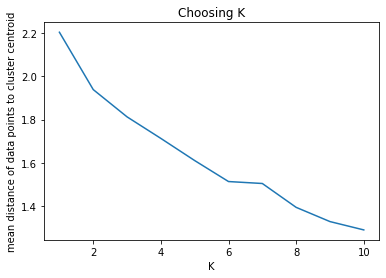

In [48]:
#Apply K-Means for several values of K
avg_distance=[]
K = 10
for k in range(1,K+1):
    inertia = cluster_quartier(k, paris_grouped)
    avg_distance.append(inertia)

plt.plot(range(1,K+1),avg_distance)
plt.title('Choosing K')
plt.xlabel('K')
plt.ylabel('mean distance of data points to cluster centroid')

A VOIR EN FONCTION DES INFOS DE SOIR PAR EX >> Applying the "elbow method", K=2 seems to be a good value to cluster our data.

In [49]:
# set number of clusters
kclusters = 4

paris_grouped_clustering = paris_grouped.drop('Quartier Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 2, 1, 2, 2, 2, 2, 2, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [50]:
# add clustering labels
quartier_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
quartier_venues_sorted

#Add Quartier Latitude and Longitude to place it on the map later on
paris_merged = df[['Latitude','Longitude', 'Quartier Name']]

# merge toronto_grouped with df (toronto data) to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(quartier_venues_sorted.set_index('Quartier Name'), on='Quartier Name')

# Drop "na" values
#toronto_merged.dropna(subset=["Cluster Labels"], axis=0, inplace=True)

# Cast Cluster Labels to int
#toronto_merged["Cluster Labels"] = toronto_merged["Cluster Labels"].astype("int64") 

In [51]:
paris_merged

Latitude  Longitude              Quartier Name  Cluster Labels  \
0   48.860211   2.336299  Saint-Germain-l'Auxerrois               1   
1   48.862466   2.346009                 Les Halles               2   
2   48.863585   2.336204               Palais-Royal               1   
3   48.867463   2.329428              Place-Vendôme               1   
4   48.869135   2.332909                    Gaillon               1   
..        ...        ...                        ...             ...   
75  48.877421   2.371020                     Combat               2   
76  48.871727   2.385085                 Belleville               2   
77  48.870362   2.406736              Saint-Fargeau               0   
78  48.861217   2.393929              Père-Lachaise               1   
79  48.854744   2.385356                   Charonne               2   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0      French Restaurant                 Hotel                 Plaza   
1      French Restaurant                Bakery              Wine Bar   
2    Japanese Restaurant     French Restaurant                  Café   
3                  Hotel   Japanese Restaurant     French Restaurant   
4    Japanese Restaurant                 Hotel     French Restaurant   
..                   ...                   ...                   ...   
75                   Bar     French Restaurant      Asian Restaurant   
76                   Bar     French Restaurant    Dim Sum Restaurant   
77                 Plaza           Supermarket     French Restaurant   
78                   Bar     French Restaurant                  Café   
79     French Restaurant                Bistro                   Bar   

   4th Most Common Venue  5th Most Common Venue 6th Most Common Venue  \
0            Coffee Shop                   Café         Historic Site   
1                  Hotel     Italian Restaurant           Pizza Place   
2                  Plaza            Coffee Shop                 Hotel   
3               Boutique          Jewelry Store          Dessert Shop   
4         Chocolate Shop      Korean Restaurant         Jewelry Store   
..                   ...                    ...                   ...   
75              Wine Bar                   Café                Bistro   
76                Bistro     Italian Restaurant    Chinese Restaurant   
77          Tram Station                 Bakery            Restaurant   
78                Bistro    Japanese Restaurant               Theater   
79                  Café  Vietnamese Restaurant    Italian Restaurant   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0             Art Museum               Exhibit        Clothing Store   
1           Cocktail Bar        Clothing Store    Chinese Restaurant   
2          Historic Site    Italian Restaurant            Art Museum   
3                  Plaza        Sandwich Place           Pastry Shop   
4            Coffee Shop        Sandwich Place              Wine Bar   
..                   ...                   ...                   ...   
75          Cocktail Bar                 Diner            Restaurant   
76            Restaurant           Pizza Place          Cocktail Bar   
77             Bookstore                  Café           Pizza Place   
78    Italian Restaurant                 Plaza                Bakery   
79             Bookstore   Japanese Restaurant   Arts & Crafts Store   

   10th Most Common Venue 11th Most Common Venue 12th Most Common Venue  \
0                     Bar         Cosmetics Shop              Bookstore   
1              Restaurant                   Café         Ice Cream Shop   
2                  Garden               Wine Bar                    Bar   
3                  Bakery              Bookstore         Chocolate Shop   
4            Concert Hall                  Plaza            Pastry Shop   
..                    ...                    ...                    ...   
75              Roof

In [52]:
# create map
map_clusters = folium.Map(location=[paris_latitude, paris_longitude], 
                          zoom_start=12, 
                          tiles='Stamen Toner')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, quartier, cluster in zip(paris_merged['Latitude'], 
                                       paris_merged['Longitude'], 
                                       paris_merged['Quartier Name'], 
                                       paris_merged['Cluster Labels']):
    label = folium.Popup(str(quartier) + '\n' 
                         + '(Cluster {})'.format(str(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

In [53]:
#create a function to analyze a cluster

def analyze_cluster(cluster_label, nb_top_categories):
    
    #Retrieve quartier name + most common venues
    cluster_to_analyze = paris_merged.loc[
        paris_merged['Cluster Labels'] == cluster_label,
        paris_merged.columns[[2] + list(range(4, paris_merged.shape[1]))]
    ]
    
    #Retrieve cluster's most important categories
    #append all the venues in a list
    val=[]
    for index, item in cluster_to_analyze.iloc[:,list(range(1, cluster_to_analyze.shape[1]))].iteritems():
        val.append(cluster_to_analyze[index].values)
    # Flatten the list
    flat_list = []
    for sublist in val:
        for item in sublist:
            flat_list.append(item)

    # Create a panda DataFrame from list
    top_venue_list = pd.DataFrame(flat_list)
    top_venue_list.rename(columns={0:'ratio'}, inplace=True)

    # Print the percentage of each categories
    cluster_main_categories = top_venue_list['ratio'].value_counts().head(nb_top_categories)*100/top_venue_list.shape[0]
    
    # transform to a dataframe
    cluster_main_categories_top = pd.DataFrame(cluster_main_categories)
    
    cluster_main_categories_top.reset_index(inplace=True)
    cluster_main_categories_top.rename(columns={'index': 'Cluster{} '.format(str(cluster_label))+'top10'}, inplace=True)    
    
    return cluster_to_analyze, cluster_main_categories_top

In [54]:
nb_top_categories = 20

### Cluster 0

In [55]:
cluster0, cluster0_main_cat = analyze_cluster(0,nb_top_categories)

In [56]:
cluster0

Quartier Name 1st Most Common Venue 2nd Most Common Venue  \
74       Amérique     French Restaurant         Metro Station   
77  Saint-Fargeau                 Plaza           Supermarket   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
74           Pizza Place           Supermarket                Bistro   
77     French Restaurant          Tram Station                Bakery   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
74                  Café       Bed & Breakfast               Theater   
77            Restaurant             Bookstore                  Café   

   9th Most Common Venue 10th Most Common Venue 11th Most Common Venue  \
74  Arts & Entertainment                   Park                   Pool   
77           Pizza Place                  Diner    Empanada Restaurant   

   12th Most Common Venue 13th Most Common Venue 14th Most Common Venue  \
74                  Plaza          Deli / Bodega     English Restaurant   
77     English Restaurant   Ethiopian Restaurant                Exhibit   

   15th Most Common Venue  
74      Food & Drink Shop  
77   Fast Food Restaurant

In [57]:
cluster0_main_cat

Cluster0 top10     ratio
0                   Café  6.666667
1      French Restaurant  6.666667
2                  Plaza  6.666667
3     English Restaurant  6.666667
4            Pizza Place  6.666667
5            Supermarket  6.666667
6                Theater  3.333333
7                Exhibit  3.333333
8                   Park  3.333333
9      Food & Drink Shop  3.333333
10          Tram Station  3.333333
11                Bistro  3.333333
12             Bookstore  3.333333
13  Arts & Entertainment  3.333333
14                  Pool  3.333333
15                Bakery  3.333333
16                 Diner  3.333333
17            Restaurant  3.333333
18         Metro Station  3.333333
19  Fast Food Restaurant  3.333333

### Cluster 1

In [58]:
cluster1, cluster1_main_cat = analyze_cluster(1,nb_top_categories)

### Cluster 2

In [59]:
cluster2, cluster2_main_cat = analyze_cluster(2,nb_top_categories)

### Cluster 3

In [60]:
cluster3, cluster3_main_cat = analyze_cluster(3,nb_top_categories)

### Cluster 4

In [61]:
#cluster4, cluster4_main_cat = analyze_cluster(4,nb_top_categories)

### Cluster 5

In [62]:
#cluster5, cluster5_main_cat = analyze_cluster(5,nb_top_categories)

### Cluster 6

In [63]:
#cluster6, cluster6_main_cat = analyze_cluster(6,nb_top_categories)

### Sumary

In [64]:
columns=['0','1']
#,'cluster2','cluster3','cluster4','cluster5','cluster6']

top10_by_cluster = pd.concat([cluster0_main_cat.iloc[:,0],
                              cluster1_main_cat.iloc[:,0],
                              cluster2_main_cat.iloc[:,0],
                              cluster3_main_cat.iloc[:,0]]
                              #cluster4_main_cat.iloc[:,0],
                              #cluster5_main_cat.iloc[:,0]]
                              #cluster6_main_cat.iloc[:,0]]
                             ,axis=1)

top10_by_cluster

Cluster0 top10       Cluster1 top10       Cluster2 top10  \
0                   Café    French Restaurant    French Restaurant   
1      French Restaurant                Hotel                Hotel   
2                  Plaza                 Café   Italian Restaurant   
3     English Restaurant               Bakery               Bakery   
4            Pizza Place  Japanese Restaurant                  Bar   
5            Supermarket   Italian Restaurant               Bistro   
6                Theater               Bistro  Japanese Restaurant   
7                Exhibit                  Bar          Coffee Shop   
8                   Park          Coffee Shop          Pizza Place   
9      Food & Drink Shop         Cocktail Bar         Burger Joint   
10          Tram Station           Restaurant           Restaurant   
11                Bistro                Plaza                 Café   
12             Bookstore             Wine Bar             Wine Bar   
13  Arts & Entertainment       Sandwich Place         Cocktail Bar   
14                  Pool   Chinese Restaurant      Thai Restaurant   
15                Bakery              Theater                Plaza   
16                 Diner          Pastry Shop   Chinese Restaurant   
17            Restaurant            Bookstore            Bookstore   
18         Metro Station          Pizza Place          Supermarket   
19  Fast Food Restaurant      Thai Restaurant                 Park   

         Cluster3 top10  
0     French Restaurant  
1                 Hotel  
2                Bakery  
3    Italian Restaurant  
4                Bistro  
5                  Café  
6   Japanese Restaurant  
7            Restaurant  
8           Coffee Shop  
9        Sandwich Place  
10            Brasserie  
11                Plaza  
12       Cosmetics Shop  
13     Sushi Restaurant  
14       Clothing Store  
15         Gourmet Shop  
16         Dessert Shop  
17   Chinese Restaurant  
18                  Bar  
19          Supermarket

## Superposition Data clustering + map

In [65]:
paris_quartier_geo = 'quartier_paris.geojson'

my_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=paris_quartier_geo,
    data=paris_music_venues_grouped_quartier,
    columns=["INSEE_ID", 'Music Venue Count'],
    key_on='feature.properties.c_quinsee',
    fill_color='GnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of music venues in a 500m radius').add_to(my_map)

#'BuGn', 'BuPu', 'GnBu',

markers_colors = []
for lat, lon, quartier, cluster in zip(paris_merged['Latitude'], 
                                       paris_merged['Longitude'], 
                                       paris_merged['Quartier Name'], 
                                       paris_merged['Cluster Labels']):
    label = folium.Popup(str(quartier) + '\n' 
                         + '(Cluster {})'.format(str(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(my_map)
    
my_map

We see here that it's not easy to identify the best spot... Our approach seems to be too much generic. 
We should probably do the same study. But this time, only use interesting location data such as music venues, bar, restaurants, etc.

On s'aperçoit que pas forcément évident, parce qu'en fait l'API foursquare ne permet pas d'avoir des infos sur un jour/une heure spécifique de la journée. 
Du coup, peut-être intéressant de faire des requêtes uniquement sur les catégories de venues qui nous intéressent. 

Malgré tout... ON peut voir que les clusters 6 sont ceux dans lesquels il y a le plus de "music venues"...
Ce qui serait donc intéressant c'est de rester sur ces clusters-ci, qui semblent bien prédire les music venues.

## Superpose jazz club

Superpose Jazz Club

In [66]:
jazz_club_ID = '4bf58dd8d48988d1e7931735'

def getNearbyJazzClubs(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            jazz_club_ID,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request        
        results = requests.get(url).json()['response']['venues']        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['categories'][0]['name'],
            v['location']['lat'], 
            v['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Quartier Name', 
                  'Quartier Latitude', 
                  'Quartier Longitude', 
                  'Venue', 
                  'Venue Category',
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

In [67]:
jazz_venues = getNearbyJazzClubs(names=df['Quartier Name'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Saint-Germain-l'Auxerrois
Les Halles
Palais-Royal
Place-Vendôme
Gaillon
Vivienne
Mail
Bonne-Nouvelle
Arts-et-Métiers
Enfants-Rouges
Archives
Sainte-Avoye
Saint-Merri
Saint-Gervais
Arsenal
Notre-Dame
Quartier Saint-Victor
Jardin-des-Plantes
Val-de-Grâce
Sorbonne
Monnaie
Odéon
Notre-Dame-des-Champs
Saint-Germain-des-Prés
Saint-Thomas-d'Aquin
Les Invalides
École-Militaire
Gros-Caillou
Champs-Élysées
Faubourg-du-Roule
La Madeleine
Europe
Saint-Georges
Chaussée-d'Antin
Faubourg-Montmartre
Rochechouart
Saint-Vincent-de-Paul
Porte-Saint-Denis
Porte-Saint-Martin
Hôpital-Saint-Louis
Folie-Méricourt
Saint-Ambroise
La Roquette
Sainte-Marguerite
Bel-Air
Picpus
Bercy
Quinze-Vingts
Salpêtrière
La Gare
Maison-Blanche
Croulebarbe
Montparnasse
Parc Montsouris
Petit-Montrouge
Plaisance
Saint-Lambert
Necker
Grenelle
Javel
Auteuil
La Muette
Porte-Dauphine
Chaillot
Les Ternes
Plaine Monceau
Batignolles
Épinettes
Grandes-Carrières
Clignancourt
Goutte-d'Or
La Chapelle
La Villette
Pont-de-Flandre
Amérique
Com

In [68]:
jazz_venues

Quartier Name  Quartier Latitude  Quartier Longitude  \
0   Saint-Germain-l'Auxerrois          48.860211            2.336299   
1   Saint-Germain-l'Auxerrois          48.860211            2.336299   
2   Saint-Germain-l'Auxerrois          48.860211            2.336299   
3   Saint-Germain-l'Auxerrois          48.860211            2.336299   
4                  Les Halles          48.862466            2.346009   
..                        ...                ...                 ...   
86                  La Muette          48.857975            2.274062   
87               Clignancourt          48.894058            2.345678   
88                La Villette          48.890489            2.380072   
89            Pont-de-Flandre          48.894728            2.382305   
90                 Belleville          48.871727            2.385085   

                     Venue     Venue Category  Venue Latitude  Venue Longitude  
0      Chez Papa Jazz Club          Jazz Club       48.855377         2.333497  
1                Jazz Club          Jazz Club       48.855308         2.333580  
2                      Q&R          Jazz Club       48.863772         2.332568  
3             Osprey Paris      Jewelry Store       48.864537         2.333134  
4            Histoire d'Or          Jazz Club       48.862384         2.346579  
..                     ...                ...             ...              ...  
86  Poocrastination Center            Brewery       48.857543         2.273827  
87                 Bab Ilo          Jazz Club       48.890337         2.344791  
88            La Gare Jazz          Jazz Club       48.895425         2.381447  
89            La Gare Jazz          Jazz Club       48.895425         2.381447  
90        La Bellevilloise  French Restaurant       48.868244         2.391971  

[91 rows x 7 columns]

In [69]:
paris_quartier_geo = 'quartier_paris.geojson'

my_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=paris_quartier_geo,
    data=paris_music_venues_grouped_quartier,
    columns=["INSEE_ID", 'Music Venue Count'],
    key_on='feature.properties.c_quinsee',
    fill_color='GnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of music venues in a 500m radius').add_to(my_map)

#'BuGn', 'BuPu', 'GnBu',

markers_colors = []
for lat, lon, quartier, cluster in zip(paris_merged['Latitude'], 
                                       paris_merged['Longitude'], 
                                       paris_merged['Quartier Name'], 
                                       paris_merged['Cluster Labels']):
    label = folium.Popup(str(quartier) + '\n' 
                         + '(Cluster {})'.format(str(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(my_map)
   
# loop through the 100 crimes and add each to the map
for lat, lng, venue, venue_category in zip(jazz_venues['Venue Latitude'], 
                                           jazz_venues['Venue Longitude'], 
                                           jazz_venues['Venue'], 
                                           jazz_venues['Venue Category']):
    folium.CircleMarker(
        [lat, lng],
        radius=3, # define how big you want the circle markers to be
        color='yellow',
        fill=True,
        popup=(venue+'\n'+'({})'.format(venue_category)),
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(my_map)

# display map
my_map



from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#ff0000;opacity:0.7;'></span>cluster 0</li>
    <li><span style='background:#8000ff;opacity:0.7;'></span>cluster 1</li>
    <li><span style='background:#2adddd;opacity:0.7;'></span>cluster 2</li>
    <li><span style='background:#d4dd80;opacity:0.7;'></span>cluster 3</li>
    <li><span style='background:yellow;opacity:0.7;'></span>Jazz clubs</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 16px;
    margin-right: 5px;
    margin-left: 0;
    border-radius: 50%;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

my_map.get_root().add_child(macro)

my_map

In [70]:
paris_quartier_geo = 'quartier_paris.geojson'

my_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=paris_quartier_geo,
    data=paris_music_venues_grouped_quartier,
    columns=["INSEE_ID", 'Music Venue Count'],
    key_on='feature.properties.c_quinsee',
    fill_color='GnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of music venues in a 500m radius').add_to(my_map)

#'BuGn', 'BuPu', 'GnBu',

markers_colors = []
for lat, lon, quartier, cluster in zip(paris_merged['Latitude'], 
                                       paris_merged['Longitude'], 
                                       paris_merged['Quartier Name'], 
                                       paris_merged['Cluster Labels']):
    label = folium.Popup(str(quartier) + '\n' 
                         + '(Cluster {})'.format(str(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(my_map)
   
# loop through the 100 crimes and add each to the map
for lat, lng, venue, venue_category in zip(jazz_venues['Venue Latitude'], 
                                           jazz_venues['Venue Longitude'], 
                                           jazz_venues['Venue'], 
                                           jazz_venues['Venue Category']):
    folium.CircleMarker(
        [lat, lng],
        radius=3, # define how big you want the circle markers to be
        color='yellow',
        fill=True,
        popup=(venue+'\n'+'({})'.format(venue_category)),
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(my_map)

my_map

Further improvements > would be interesting to add data about pedestrian activities at night. We would know where are the hot spots in tows with the most people getting around. 

Jazz clubs are generally around cluster 0,1 and 2

In [71]:
paris_quartier_geo = 'quartier_paris.geojson'

my_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=paris_quartier_geo,
    data=paris_music_venues_grouped_quartier,
    columns=["INSEE_ID", 'Music Venue Count'],
    key_on='feature.properties.c_quinsee',
    fill_color='GnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of music venues in a 500m radius').add_to(my_map)
# display map
my_map

In [72]:
paris_quartier_geo = 'quartier_paris.geojson'

my_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=paris_quartier_geo,
    data=paris_music_venues_grouped_quartier,
    columns=["INSEE_ID", 'Music Venue Count'],
    key_on='feature.properties.c_quinsee',
    fill_color='GnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of music venues in a 500m radius').add_to(my_map)

#'BuGn', 'BuPu', 'GnBu',

# loop through the 100 crimes and add each to the map
for lat, lng, venue, venue_category in zip(paris_music_venues['Venue Latitude'], 
                                           paris_music_venues['Venue Longitude'], 
                                           paris_music_venues['Venue'], 
                                           paris_music_venues['Venue Category']):
    folium.CircleMarker(
        [lat, lng],
        radius=3, # define how big you want the circle markers to be
        color='red',
        fill=True,
        popup=(venue+'\n'+'({})'.format(venue_category)),
        fill_color='red',
        fill_opacity=0.6
    ).add_to(my_map)


for lat, lng, venue, venue_category in zip(jazz_venues['Venue Latitude'], 
                                           jazz_venues['Venue Longitude'], 
                                           jazz_venues['Venue'], 
                                           jazz_venues['Venue Category']):
    folium.CircleMarker(
        [lat, lng],
        radius=3, # define how big you want the circle markers to be
        color='yellow',
        fill=True,
        popup=(venue+'\n'+'({})'.format(venue_category)),
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(my_map)
    
my_map

In [73]:
paris_quartier_geo = 'quartier_paris.geojson'

my_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=paris_quartier_geo,
    data=paris_music_venues_grouped_quartier,
    columns=["INSEE_ID", 'Music Venue Count'],
    key_on='feature.properties.c_quinsee',
    fill_color='GnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of music venues in a 500m radius').add_to(my_map)

#'BuGn', 'BuPu', 'GnBu',

markers_colors = []
for lat, lon, quartier, cluster in zip(paris_merged['Latitude'], 
                                       paris_merged['Longitude'], 
                                       paris_merged['Quartier Name'], 
                                       paris_merged['Cluster Labels']):
    label = folium.Popup(str(quartier) + '\n' 
                         + '(Cluster {})'.format(str(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(my_map)
   
# display map
my_map



from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#ff0000;opacity:0.7;'></span>cluster 0</li>
    <li><span style='background:#8000ff;opacity:0.7;'></span>cluster 1</li>
    <li><span style='background:#2adddd;opacity:0.7;'></span>cluster 2</li>
    <li><span style='background:#d4dd80;opacity:0.7;'></span>cluster 3</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 16px;
    margin-right: 5px;
    margin-left: 0;
    border-radius: 50%;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

my_map.get_root().add_child(macro)

my_map

## Conclusion

In [155]:
cluster1.shape[0]+cluster2.shape[0]

65

In [156]:
#Group high potential clusters cluster 1 and 2
df_jazz_clusters = cluster1[['Quartier Name']]
df_jazz_clusters = df_jazz_clusters.append(cluster2[['Quartier Name']],ignore_index=True)
df_jazz_clusters.shape[0]

65

In [157]:
#Count the number of jazz venues per quartier
jazz_venues_per_quartier = jazz_venues[['Quartier Name','Venue']].groupby('Quartier Name').count()
jazz_venues_per_quartier.shape

(39, 1)

In [158]:
jazz_venues_per_quartier.reset_index(inplace=True)

In [159]:
df_jazz_clusters

Quartier Name
0   Saint-Germain-l'Auxerrois
1                Palais-Royal
2               Place-Vendôme
3                     Gaillon
4                    Vivienne
..                        ...
60          Grandes-Carrières
61               Clignancourt
62                     Combat
63                 Belleville
64                   Charonne

[65 rows x 1 columns]

In [160]:
df_jazz_high_pot = df_jazz_clusters.merge(jazz_venues_per_quartier,how='left')
df_jazz_high_pot.rename(columns={'Venue': 'Count of Jazz Venue'},inplace=True)
df_jazz_high_pot.fillna(0,inplace=True)

#find frequency of venues xnew = 1 - xold/xmax (1- parce qu'on pense que moins il y a de clubs, mieux c'est)
df_jazz_high_pot['1 - normalized count'] = 1 - df_jazz_high_pot['Count of Jazz Venue']/df_jazz_high_pot['Count of Jazz Venue'].max()

In [164]:
df_jazz_high_pot

Quartier Name  Count of Jazz Venue  1 - normalized count
0   Saint-Germain-l'Auxerrois                  4.0                 0.500
1                Palais-Royal                  2.0                 0.750
2               Place-Vendôme                  2.0                 0.750
3                     Gaillon                  1.0                 0.875
4                    Vivienne                  0.0                 1.000
..                        ...                  ...                   ...
60          Grandes-Carrières                  0.0                 1.000
61               Clignancourt                  1.0                 0.875
62                     Combat                  0.0                 1.000
63                 Belleville                  1.0                 0.875
64                   Charonne                  0.0                 1.000

[65 rows x 3 columns]

In [165]:
df_jazz_high_pot = df_jazz_high_pot.merge(paris_music_venues_grouped_quartier,
                                          left_on='Quartier Name',
                                          right_on='Quartier Name_y')

df_jazz_high_pot.drop('Quartier Name_y',1,inplace=True)


df_jazz_high_pot[['Music Venue Count']]=df_jazz_high_pot[['Music Venue Count']]/df_jazz_high_pot[['Music Venue Count']].max()

In [166]:
df_jazz_high_pot

Quartier Name  Count of Jazz Venue  1 - normalized count  \
0   Saint-Germain-l'Auxerrois                  4.0                 0.500   
1                Palais-Royal                  2.0                 0.750   
2               Place-Vendôme                  2.0                 0.750   
3                     Gaillon                  1.0                 0.875   
4                    Vivienne                  0.0                 1.000   
..                        ...                  ...                   ...   
60          Grandes-Carrières                  0.0                 1.000   
61               Clignancourt                  1.0                 0.875   
62                     Combat                  0.0                 1.000   
63                 Belleville                  1.0                 0.875   
64                   Charonne                  0.0                 1.000   

    Music Venue Count  INSEE_ID  
0            0.588235   7510101  
1            0.294118   7510103  
2            0.529412   7510104  
3            0.470588   7510201  
4            0.529412   7510202  
..                ...       ...  
60           0.058824   7511801  
61           0.176471   7511802  
62           0.294118   7511904  
63           0.352941   7512001  
64           0.411765   7512004  

[65 rows x 5 columns]

In [169]:
df_jazz_high_pot["rating"] = df_jazz_high_pot['1 - normalized count']*df_jazz_high_pot['Music Venue Count']

In [170]:
df_jazz_high_pot.head(20)

Quartier Name  Count of Jazz Venue  1 - normalized count  \
0   Saint-Germain-l'Auxerrois                  4.0                 0.500   
1                Palais-Royal                  2.0                 0.750   
2               Place-Vendôme                  2.0                 0.750   
3                     Gaillon                  1.0                 0.875   
4                    Vivienne                  0.0                 1.000   
5                        Mail                  1.0                 0.875   
6              Bonne-Nouvelle                  1.0                 0.875   
7             Arts-et-Métiers                  1.0                 0.875   
8              Enfants-Rouges                  2.0                 0.750   
9                    Archives                  2.0                 0.750   
10               Sainte-Avoye                  7.0                 0.125   
11                Saint-Merri                  8.0                 0.000   
12         Jardin-des-Plantes                  0.0                 1.000   
13                   Sorbonne                  6.0                 0.250   
14                      Odéon                  8.0                 0.000   
15      Notre-Dame-des-Champs                  1.0                 0.875   
16     Saint-Germain-des-Prés                  4.0                 0.500   
17           Chaussée-d'Antin                  1.0                 0.875   
18                La Roquette                  0.0                 1.000   
19                     Picpus                  0.0                 1.000   

    Music Venue Count  INSEE_ID    rating  
0            0.588235   7510101  0.294118  
1            0.294118   7510103  0.220588  
2            0.529412   7510104  0.397059  
3            0.470588   7510201  0.411765  
4            0.529412   7510202  0.529412  
5            0.647059   7510203  0.566176  
6            1.000000   7510204  0.875000  
7            0.294118   7510301  0.257353  
8            0.470588   7510302  0.352941  
9            0.294118   7510303  0.220588  
10           0.705882   7510304  0.088235  
11           0.764706   7510401  0.000000  
12           0.058824   7510502  0.058824  
13           0.529412   7510504  0.132353  
14           0.882353   7510602  0.000000  
15           0.117647   7510603  0.102941  
16           0.529412   7510604  0.264706  
17           0.470588   7510902  0.411765  
18           0.235294   7511103  0.235294  
19           0.000000   7511202  0.000000

Display "rating" information

In [176]:
highest_pot = df_jazz_high_pot[['Quartier Name', 'rating']].sort_values('rating', ascending=False).reset_index(drop=True)
highest_pot.head(15)

Quartier Name    rating
0        Bonne-Nouvelle  0.875000
1       Folie-Méricourt  0.772059
2                  Mail  0.566176
3   Faubourg-Montmartre  0.566176
4     Porte-Saint-Denis  0.566176
5              Vivienne  0.529412
6         Saint-Georges  0.514706
7    Porte-Saint-Martin  0.441176
8              Charonne  0.411765
9               Gaillon  0.411765
10     Chaussée-d'Antin  0.411765
11                Bercy  0.411765
12        Place-Vendôme  0.397059
13  Hôpital-Saint-Louis  0.360294
14       Saint-Ambroise  0.360294

In [171]:

my_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=paris_quartier_geo,
    data=df_jazz_high_pot,
    columns=["INSEE_ID", 'rating'],
    key_on='feature.properties.c_quinsee',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Potential for a new Jazz Club').add_to(my_map)

my_map